In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold 

from sklearn.model_selection import ShuffleSplit
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet

from sklearn import metrics
import sklearn

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape)
print(test.shape)
display(train)

# Вот эти строки нужно будет убрать из теста, т.к. это невозможные параметры для бриллианта
print((test[test["x"]==0].index, test[test["y"]==0].index, test[test["z"]==0].index))

(40455, 10)
(13485, 9)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.55,Ideal,I,SI1,61.7,55.0,1134,5.29,5.31,3.27
1,0.94,Premium,E,SI1,62.4,56.0,4580,6.27,6.24,3.90
2,0.33,Premium,E,SI2,60.0,59.0,594,4.49,4.47,2.69
3,0.31,Ideal,D,VS2,59.4,56.0,879,4.45,4.40,2.63
4,2.01,Very Good,H,SI1,62.8,59.0,17759,7.99,8.04,5.03
...,...,...,...,...,...,...,...,...,...,...
40450,1.50,Very Good,D,SI1,60.7,62.0,11442,7.30,7.33,4.44
40451,1.51,Ideal,D,SI1,61.9,57.0,11834,7.35,7.42,4.57
40452,0.42,Ideal,G,SI2,60.9,56.0,971,4.87,4.89,2.97
40453,2.05,Premium,E,SI2,59.7,59.0,17237,8.39,8.27,4.97


(Int64Index([], dtype='int64'), Int64Index([], dtype='int64'), Int64Index([1929, 3313, 4996, 7633, 8103, 9279], dtype='int64'))


In [8]:
# Убираем значения бриллиантов с 0 параметром высоты, ширины и глубины

train = train.drop(train[train["x"] == 0].index)
train = train.drop(train[train["y"] == 0].index)
train = train.drop(train[train["z"] == 0].index)

print(train.shape)

display(test[test["z"] == 0])
test = test.drop(test[test["x"] == 0].index)
test = test.drop(test[test["y"] == 0].index)
test = test.drop(test[test["z"] == 0].index)

print(test.shape)

(40441, 10)


,carat,cut,color,clarity,depth,table,x,y,z
1929,2.18,Premium,H,SI2,59.4,61.0,8.49,8.45,0.0
3313,1.50,Good,G,I1,64.0,61.0,7.15,7.04,0.0
4996,2.80,Good,G,SI2,63.8,58.0,8.90,8.85,0.0
7633,1.10,Premium,G,SI2,63.0,59.0,6.50,6.47,0.0
8103,2.20,Premium,H,SI1,61.2,59.0,8.42,8.37,0.0
9279,1.01,Premium,H,I1,58.1,59.0,6.66,6.60,0.0


(13479, 9)


In [9]:
# Определим столбцы с категориальными данными
obj = (train.dtypes == "object")
object_cols = list(obj[obj].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
['cut', 'color', 'clarity']


In [10]:
# Задаем словарь, где задаем иерархию параметров от "плохих" к "хорошим" в числовом выражении
# Изначально пытался сделать через label encoder, но тот не учитывает иерархию, которая в нашем случае важна
cut_quality = {"Fair": 1, "Good": 2, "Very Good": 3, "Premium": 4, "Ideal": 5}

# 'color' будет варьироваться от 1 ('J') до 7 ('D')
color_quality = {"D": 7, "E": 6, "F": 5, "G": 4, "H": 3, "I": 2, "J": 1}

# 'clarity' качество тоже имеет 7 параметров от ('I1') до ('IF')
clarity_quality = {
    "I1": 1,
    "SI2": 2,
    "SI1": 3,
    "VS2": 4,
    "VS1": 5,
    "VVS2": 6,
    "VVS1": 7,
    "IF": 8,
}

In [11]:
# Применяем этот словарь к тренировочным и тестовым данным
train_123 = train.copy()

train_123["cut"] = train_123["cut"].apply(lambda x: cut_quality[x])
train_123["color"] = train_123["color"].apply(lambda x: color_quality[x])
train_123["clarity"] = train_123["clarity"].apply(lambda x: clarity_quality[x])

test_123 = test.copy()

test_123["cut"] = test_123["cut"].apply(lambda x: cut_quality[x])
test_123["color"] = test_123["color"].apply(lambda x: color_quality[x])
test_123["clarity"] = test_123["clarity"].apply(lambda x: clarity_quality[x])

test_123

,carat,cut,color,clarity,depth,table,x,y,z
0,1.52,1,3,4,62.1,66.0,7.33,7.13,4.50
1,0.54,4,4,4,62.0,58.0,5.21,5.18,3.22
2,0.70,4,6,4,62.0,60.0,5.70,5.59,3.50
3,0.59,5,6,4,62.2,58.0,5.35,5.39,3.34
4,0.86,4,5,2,61.8,58.0,6.12,6.15,3.79
...,...,...,...,...,...,...,...,...,...
13480,1.51,3,6,4,62.4,58.0,7.26,7.33,4.55
13481,1.00,5,2,5,63.1,57.0,6.32,6.39,4.01
13482,0.70,3,6,3,59.6,63.0,5.72,5.65,3.39
13483,0.58,5,5,3,62.2,57.0,5.37,5.33,3.33


<AxesSubplot:>

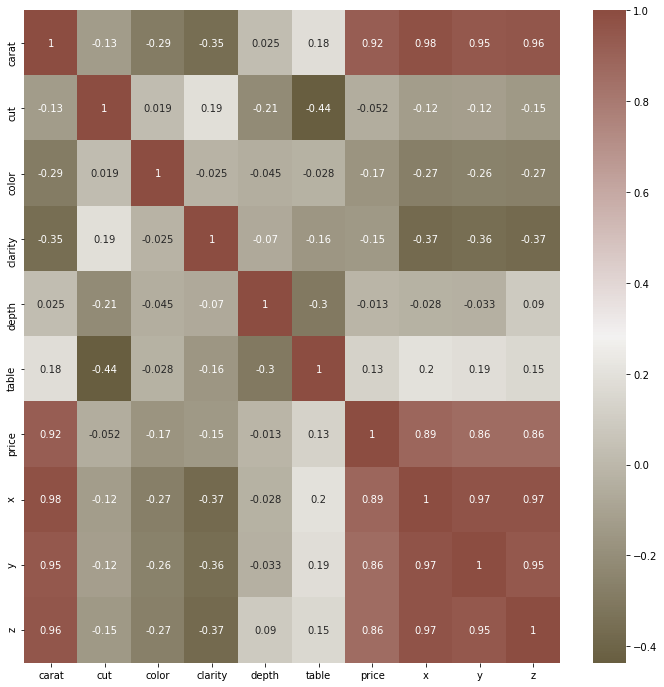

In [12]:
# Корреляционная матрица
# Больше всего на цену влияют параметры размера бриллианта и его картаты, что логично
cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= train_123.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap=cmap,annot=True)

In [13]:
train_123.describe()
train.keys()
general_train_X = train_123.loc[:, ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']]
general_train_y = train_123.loc[:, ['price']]

In [14]:
X = train_123.drop('price', axis=1)
y = train_123.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X

,carat,cut,color,clarity,depth,table,x,y,z
0,0.55,5,2,3,61.7,55.0,5.29,5.31,3.27
1,0.94,4,6,3,62.4,56.0,6.27,6.24,3.90
2,0.33,4,6,2,60.0,59.0,4.49,4.47,2.69
3,0.31,5,7,4,59.4,56.0,4.45,4.40,2.63
4,2.01,3,3,3,62.8,59.0,7.99,8.04,5.03
...,...,...,...,...,...,...,...,...,...
40450,1.50,3,7,3,60.7,62.0,7.30,7.33,4.44
40451,1.51,5,7,3,61.9,57.0,7.35,7.42,4.57
40452,0.42,5,4,2,60.9,56.0,4.87,4.89,2.97
40453,2.05,4,6,2,59.7,59.0,8.39,8.27,4.97


In [15]:
from sklearn.metrics import mean_absolute_error

In [16]:
# Регрессия со StandardScaler
diam_pip_st=make_pipeline(StandardScaler(), LinearRegression() )
diam_pip_st.fit(X_train, y_train)

print("R-квадрат обучение: {:.2f}".format(diam_pip_st.score(X_train, y_train))) 
print("R-квадрат тест: {:.2f}".format(diam_pip_st.score(X_test, y_test)))
print("-------------------------------")

print("diam_pip_st.coef_: {}".format( diam_pip_st.named_steps['linearregression'].coef_ )) 
print("diam_pip_st.intercept_: {}".format( diam_pip_st.named_steps['linearregression'].intercept_  ))


R-квадрат обучение: 0.91
R-квадрат тест: 0.90
-------------------------------
diam_pip_st.coef_: [5148.73073289  120.44603995  552.73576743  836.34497195  -37.80606945
  -80.14395874 -566.29123452  302.25600979 -715.44492722]
diam_pip_st.intercept_: 3956.70365267769


In [17]:
# Регрессия со MinMaxScaler
diam_pip_mm = make_pipeline(MinMaxScaler(), LinearRegression())
diam_pip_mm.fit(X_train, y_train)

print("R-квадрат обучение: {:.2f}".format(diam_pip_mm.score(X_train, y_train))) 
print("R-квадрат тест: {:.2f}".format(diam_pip_mm.score(X_test, y_test)))
print("-------------------------------")

print("diam_pip_mm.coef_: {}".format( diam_pip_mm.named_steps['linearregression'].coef_ )) 
print("diam_pip_mm.intercept_: {}".format( diam_pip_mm.named_steps['linearregression'].intercept_  ))

R-квадрат обучение: 0.91
R-квадрат тест: 0.90
-------------------------------
diam_pip_mm.coef_: [46550.52647437   431.4596841   1944.84732424  3536.74762216
  -928.30801347 -1861.1996925  -3278.90574384  7545.72548999
 -5833.7760957 ]
diam_pip_mm.intercept_: -1470.240043940199


In [18]:
from sklearn.linear_model import Ridge
diam_ridge_1 = make_pipeline(MinMaxScaler(),
                          PolynomialFeatures(degree=2, include_bias=False), 
                          Ridge() 
                         )
kfold = KFold(n_splits=10, shuffle=True)
param_grid =[
    {'ridge__alpha':[.01, .02, .03, .04, .05, .06, .07, .08, .09]}
     ]
grid = GridSearchCV(diam_ridge_1, param_grid, cv=kfold, return_train_score=True)
grid.fit(X_train,y_train)
print("R^2 наилучшей модели кроссвалидации на валидационных тестовых наборах: {:.6f}\n".format(grid.best_score_)) 
print("R^2 для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid.score(X_test, y_test)))
print("Наилучшие параметры:\n{}\n".format(grid.best_params_))

R^2 наилучшей модели кроссвалидации на валидационных тестовых наборах: 0.428124

R^2 для наилучшей модели на тестовом наборе: 0.229706

Наилучшие параметры:
{'ridge__alpha': 0.09}



In [19]:
# Lasso
diam_lasso=make_pipeline(MinMaxScaler(),
                          PolynomialFeatures(degree=2, include_bias=False), 
                          Lasso(alpha=0.08, max_iter=100000) 
                         )
diam_lasso = diam_lasso.fit(X_train, y_train)

print("R-квадрат на обучающем наборе: {:.2f}".format(diam_lasso.score(X_train, y_train))) 
print("R-квадрат на тестовом наборе: {:.2f}".format(diam_lasso.score(X_test, y_test))) 
print("Количество использованных признаков: {}".format(np.sum(diam_lasso.named_steps['lasso'].coef_ != 0)))

R-квадрат на обучающем наборе: 0.96
R-квадрат на тестовом наборе: 0.96
Количество использованных признаков: 31


In [20]:
# ElasticNet
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y) 
diam_net=make_pipeline(MinMaxScaler(),
                          PolynomialFeatures(degree=2, include_bias=False), 
                          ElasticNet() 
                         )
pipe_net = Pipeline([('preprocessing', MinMaxScaler()),
                 ('features', PolynomialFeatures(degree=2, include_bias=False)),
                 ('regresion', ElasticNet(tol=0.1))])

cv=ShuffleSplit(n_splits=10,  test_size=0.3, train_size=0.7)
param_grid =[
    {'regresion__l1_ratio': [0.5, .6, .7, .8, .9, .99, 1],
     'regresion__alpha': [10**(-7),10**(-6),10**(-5),10**(-4), 10**(-3), 10**(-2), 10**(-1)]
     }
]

grid = GridSearchCV(pipe_net, param_grid, cv=cv, return_train_score=True)
grid.fit(X_train,y_train)

print("Словарь с параметрами для лучшего решения:\n{}\n".format(grid.best_params_))
print("Осредненный R-квадрат для наилучшей модели кроссвалидации на проверочных тренировочных наборах: {:.6f}\n".format(grid.best_score_))
print("R-квадрат на тестовом наборе: {:.2f}".format(grid.score(X_test, y_test)))
gridresults = pd.DataFrame(grid.cv_results_)
display(gridresults.sort_values(["rank_test_score"]).T)
grid.best_estimator_

Словарь с параметрами для лучшего решения:
{'regresion__alpha': 0.1, 'regresion__l1_ratio': 1}

Осредненный R-квадрат для наилучшей модели кроссвалидации на проверочных тренировочных наборах: 0.925053

R-квадрат на тестовом наборе: 0.93


,48,41,33,25,14,15,34,16,17,26,...,28,38,37,36,35,46,45,44,43,42
mean_fit_time,0.027869,0.037057,0.027234,0.026579,0.026893,0.031252,0.027201,0.028219,0.027849,0.026967,...,0.026445,0.034552,0.033483,0.034996,0.032392,0.034917,0.039732,0.038102,0.042184,0.038449
std_fit_time,0.002041,0.002159,0.000861,0.000666,0.001661,0.003127,0.000449,0.002116,0.000779,0.000876,...,0.000766,0.002149,0.001691,0.002212,0.001303,0.00367,0.00294,0.001369,0.007646,0.004245
mean_score_time,0.007849,0.009231,0.007379,0.007364,0.008027,0.008497,0.007419,0.007855,0.007216,0.007492,...,0.007341,0.008092,0.007692,0.007331,0.007404,0.007745,0.007742,0.007791,0.008234,0.007843
std_score_time,0.000713,0.000625,0.000187,0.000289,0.001078,0.00107,0.000263,0.001259,0.000091,0.000315,...,0.000149,0.001515,0.001116,0.000207,0.00026,0.001017,0.000607,0.00041,0.000743,0.000549
param_regresion__alpha,0.1,0.01,0.001,0.0001,0.00001,0.00001,0.001,0.00001,0.00001,0.0001,...,0.001,0.01,0.01,0.01,0.01,0.1,0.1,0.1,0.1,0.1
param_regresion__l1_ratio,1,1,0.99,0.9,0.5,0.6,1,0.7,0.8,0.99,...,0.5,0.8,0.7,0.6,0.5,0.9,0.8,0.7,0.6,0.5
params,"{'regresion__alpha': 0.1, 'regresion__l1_ratio...","{'regresion__alpha': 0.01, 'regresion__l1_rati...","{'regresion__alpha': 0.001, 'regresion__l1_rat...","{'regresion__alpha': 0.0001, 'regresion__l1_ra...","{'regresion__alpha': 1e-05, 'regresion__l1_rat...","{'regresion__alpha': 1e-05, 'regresion__l1_rat...","{'regresion__alpha': 0.001, 'regresion__l1_rat...","{'regresion__alpha': 1e-05, 'regresion__l1_rat...","{'regresion__alpha': 1e-05, 'regresion__l1_rat...","{'regresion__alpha': 0.0001, 'regresion__l1_ra...",...,"{'regresion__alpha': 0.001, 'regresion__l1_rat...","{'regresion__alpha': 0.01, 'regresion__l1_rati...","{'regresion__alpha': 0.01, 'regresion__l1_rati...","{'regresion__alpha': 0.01, 'regresion__l1_rati...","{'regresion__alpha': 0.01, 'regresion__l1_rati...","{'regresion__alpha': 0.1, 'regresion__l1_ratio...","{'regresion__alpha': 0.1, 'regresion__l1_ratio...","{'regresion__alpha': 0.1, 'regresion__l1_ratio...","{'regresion__alpha': 0.1, 'regresion__l1_ratio...","{'regresion__alpha': 0.1, 'regresion__l1_ratio..."
split0_test_score,0.92567,0.925579,0.925475,0.925471,0.925501,0.925507,0.925539,0.925514,0.92552,0.925528,...,0.920655,0.918813,0.910805,0.90503,0.900094,0.883308,0.852435,0.8198,0.787009,0.755139
split1_test_score,0.926061,0.925516,0.925535,0.925528,0.925477,0.925465,0.92542,0.925452,0.925439,0.925426,...,0.916901,0.92015,0.913086,0.907832,0.90357,0.887137,0.861863,0.833983,0.805706,0.777811
split2_test_score,0.919462,0.91766,0.917631,0.91761,0.917509,0.917489,0.917429,0.917468,0.917447,0.917427,...,0.918219,0.733837,0.6865,0.664656,0.660423,0.518416,0.479098,0.520483,0.552131,0.573923


Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('features', PolynomialFeatures(include_bias=False)),
                ('regresion', ElasticNet(alpha=0.1, l1_ratio=1, tol=0.1))])

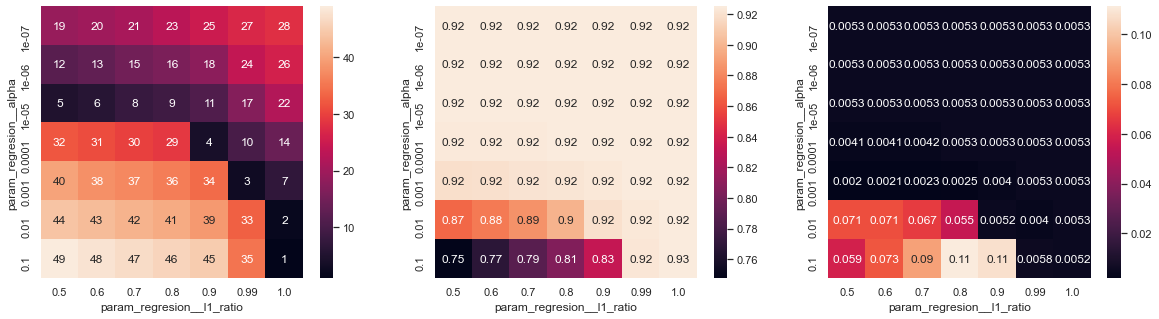

In [21]:
sns.set()
fig,ax = plt.subplots(1, 3, figsize=(20,5))

ax = plt.subplot(1, 3, 1)
pvt_rank = gridresults.pivot(index ='param_regresion__alpha', columns = 'param_regresion__l1_ratio',
                             values = 'rank_test_score')
sns.heatmap(pvt_rank,annot=True);
ax = plt.subplot(1, 3, 2)
pvt_mean = gridresults.pivot(index ='param_regresion__alpha', columns = 'param_regresion__l1_ratio',
                             values = 'mean_test_score')
sns.heatmap(pvt_mean,annot=True);
ax = plt.subplot(1, 3, 3)
pvt_std = gridresults.pivot(index = 'param_regresion__alpha', columns ='param_regresion__l1_ratio',
                            values = 'std_test_score')
sns.heatmap(pvt_std,annot=True);

In [22]:
# Таким образом, лучшая модель была получена с помощью ElasticNet регрессии. 
# Полученный R^2 = 0.92 на тестовом отрезке

In [23]:
# Сама модель
model = Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('features', PolynomialFeatures(include_bias=False)),
                ('regresion', ElasticNet(alpha=0.1, l1_ratio=1, tol=0.1))])

In [24]:
model.fit(general_train_X, general_train_y)
diam_predict = model.predict(test_123)
diam_predict

array([9353.0130846 , 1629.39858004, 3559.48932504, ..., 2845.18679583,
       1812.31226722, 1634.73483395])